In [56]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve,average_precision_score,plot_roc_curve,plot_precision_recall_curve
from sklearn.model_selection import learning_curve

In [2]:
df = pd.read_csv('archive/UNSW_NB15_training-set.csv')

# Data Set Observation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [14]:
df.head()

id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1           0                 0           1           2                0   
2           0                 0           1           3                0   
3           0                 0           2           3                0   
4           0                 0           2           3                0   

   attack_cat  label  
0      Normal      0  
1      Normal      0  
2      Normal      0  
3      Normal      0  
4      Normal      0  

[5 rows x 45 columns]

In [4]:
# selection attributs categoriels
categories_columns = df.select_dtypes(include=['object']).columns.values
print(categories_columns)

df[categories_columns]

['proto' 'service' 'state' 'attack_cat']


proto service state attack_cat
0       udp       -   INT     Normal
1       udp       -   INT     Normal
2       udp       -   INT     Normal
3       udp       -   INT     Normal
4       udp       -   INT     Normal
...     ...     ...   ...        ...
82327   udp       -   INT     Normal
82328   tcp       -   FIN     Normal
82329   arp       -   INT     Normal
82330   arp       -   INT     Normal
82331   udp       -   INT     Normal

[82332 rows x 4 columns]

In [5]:
# selection des attributs numeriques
numerical_columns = df.select_dtypes(include=[np.number]).columns.values
print(numerical_columns)

# affichage des statistiques
df[numerical_columns[1:-1]].agg(['min','max','mean','median','std'])

['id' 'dur' 'spkts' 'dpkts' 'sbytes' 'dbytes' 'rate' 'sttl' 'dttl' 'sload'
 'dload' 'sloss' 'dloss' 'sinpkt' 'dinpkt' 'sjit' 'djit' 'swin' 'stcpb'
 'dtcpb' 'dwin' 'tcprtt' 'synack' 'ackdat' 'smean' 'dmean' 'trans_depth'
 'response_body_len' 'ct_srv_src' 'ct_state_ttl' 'ct_dst_ltm'
 'ct_src_dport_ltm' 'ct_dst_sport_ltm' 'ct_dst_src_ltm' 'is_ftp_login'
 'ct_ftp_cmd' 'ct_flw_http_mthd' 'ct_src_ltm' 'ct_srv_dst'
 'is_sm_ips_ports' 'label']


dur         spkts         dpkts        sbytes        dbytes  \
min      0.000000      1.000000      0.000000  2.400000e+01  0.000000e+00   
max     59.999989  10646.000000  11018.000000  1.435577e+07  1.465753e+07   
mean     1.006756     18.666472     17.545936  7.993908e+03  1.323379e+04   
median   0.014138      6.000000      2.000000  5.340000e+02  1.780000e+02   
std      4.710444    133.916353    115.574086  1.716423e+05  1.514715e+05   

                rate        sttl        dttl         sload         dload  ...  \
min     0.000000e+00    0.000000    0.000000  0.000000e+00  0.000000e+00  ...   
max     1.000000e+06  255.000000  253.000000  5.268000e+09  2.082111e+07  ...   
mean    8.241089e+04  180.967667   95.713003  6.454902e+07  6.305470e+05  ...   
median  2.650177e+03  254.000000   29.000000  5.770032e+05  2.112951e+03  ...   
std     1.486204e+05  101.513358  116.667722  1.798618e+08  2.393001e+06  ...   

        ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
min       1.000000          1.000000          1.000000        1.000000   
max      59.000000         59.000000         38.000000       63.000000   
mean      5.744923          4.928898          3.663011        7.456360   
median    2.000000          1.000000          1.000000        3.000000   
std       8.418112          8.389545          5.915386       11.415191   

        is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
min         0.000000    0.000000          0.000000    1.000000    1.000000   
max         2.000000    2.000000         16.000000   60.000000   62.000000   
mean        0.008284    0.008381          0.129743    6.468360    9.164262   
median      0.000000    0.000000          0.000000    3.000000    5.000000   
std         0.091171    0.092485          0.638683    8.543927   11.121413   

        is_sm_ips_ports  
min            0.000000  
max            1.000000  
mean           0.011126  
median         0.000000  
std            0.104891  

[5 rows x 39 columns]

# Evaluation of the training dataset

In [6]:
# Check whether the positive label (1) match attack categories and whether attack categories match labelled data
# 0 means normal and 1 attack records 
df.groupby(['label','attack_cat'])['label','attack_cat'].count()

/home/kallen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


label  attack_cat
label attack_cat                       
0     Normal          37000       37000
1     Analysis          677         677
      Backdoor          583         583
      DoS              4089        4089
      Exploits        11132       11132
      Fuzzers          6062        6062
      Generic         18871       18871
      Reconnaissance   3496        3496
      Shellcode         378         378
      Worms              44          44

On remarque le label 0 correspond toujours à la categorie normale; et le label 1 correspond aux autre categories. Le match est donc parfait.

In [7]:
# Which is the number of occurrences for each attack category?
df.attack_cat.value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [8]:
# Which protocols and services appear in the positively labelled entries? In the negatively labelled ones?

# les protocoles
print('les protocoles :', df[df.label == 1]['proto'].unique())
# les services
print('les services :', df[df.label == 1]['service'].unique())

les protocoles : ['ospf' 'sctp' 'gre' 'udp' 'tcp' 'ggp' 'ip' 'ipnip' 'st2' 'argus' 'chaos'
 'egp' 'emcon' 'nvp' 'pup' 'xnet' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1'
 'trunk-2' 'xns-idp' 'leaf-1' 'leaf-2' 'irtp' 'rdp' 'netblt' 'mfe-nsp'
 'merit-inp' '3pc' 'idpr' 'ddp' 'idpr-cmtp' 'tp++' 'ipv6' 'sdrp'
 'ipv6-frag' 'ipv6-route' 'idrp' 'mhrp' 'i-nlsp' 'rvd' 'mobile' 'narp'
 'skip' 'tlsp' 'ipv6-no' 'any' 'ipv6-opts' 'cftp' 'sat-expak' 'ippc'
 'kryptolan' 'sat-mon' 'cpnx' 'wsn' 'pvp' 'br-sat-mon' 'sun-nd' 'wb-mon'
 'vmtp' 'ttp' 'vines' 'nsfnet-igp' 'dgp' 'eigrp' 'tcf' 'sprite-rpc' 'larp'
 'mtp' 'ax.25' 'ipip' 'aes-sp3-d' 'micp' 'encap' 'pri-enc' 'gmtp' 'ifmp'
 'pnni' 'qnx' 'scps' 'cbt' 'bbn-rcc' 'igp' 'bna' 'swipe' 'visa' 'ipcv'
 'cphb' 'iso-tp4' 'wb-expak' 'sep' 'secure-vmtp' 'xtp' 'il' 'rsvp' 'unas'
 'fc' 'iso-ip' 'etherip' 'pim' 'aris' 'a/n' 'ipcomp' 'snp' 'compaq-peer'
 'ipx-n-ip' 'pgm' 'vrrp' 'l2tp' 'zero' 'ddx' 'iatp' 'stp' 'srp' 'uti' 'sm'
 'smp' 'isis' 'ptp' 'fire' 'crtp' 'crudp' 'sccopmce

In [ ]:
# What do you conclude about the traffic being analysed?

# Data Visualisation


In [90]:
#plt.style.use('seaborn')

In [9]:
df.service.value_counts().plot(kind='bar',title='repartition des services')
plt.show()

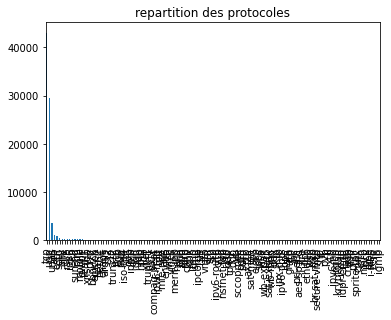

In [10]:
df.proto.value_counts().plot(kind='bar',title='repartition des protocoles')
plt.show()

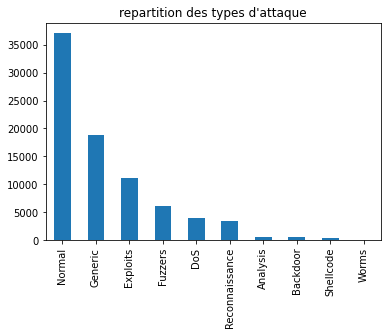

In [12]:
df.attack_cat.value_counts().plot(kind='bar',title='repartition des types d\'attaque')
plt.show()

In [99]:
# matrice de correlation

plt.subplots(figsize=(20,15))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Data cleaning

In [13]:
X = df.copy()

In [14]:
categories_columns = categories_columns[ categories_columns != 'attack_cat']

In [15]:
# create dummies variables for  string fields
X = pd.get_dummies(X, columns=categories_columns)

# retrieve the target
y = X.label 

# remove the targets and the id columns
X.drop(['id','label','attack_cat'], inplace=True, axis=1)


X.head()

dur  spkts  dpkts  sbytes  dbytes         rate  sttl  dttl  \
0  0.000011      2      0     496       0   90909.0902   254     0   
1  0.000008      2      0    1762       0  125000.0003   254     0   
2  0.000005      2      0    1068       0  200000.0051   254     0   
3  0.000006      2      0     900       0  166666.6608   254     0   
4  0.000010      2      0    2126       0  100000.0025   254     0   

         sload  dload  ...  service_snmp  service_ssh  service_ssl  state_ACC  \
0  180363632.0    0.0  ...             0            0            0          0   
1  881000000.0    0.0  ...             0            0            0          0   
2  854400000.0    0.0  ...             0            0            0          0   
3  600000000.0    0.0  ...             0            0            0          0   
4  850400000.0    0.0  ...             0            0            0          0   

   state_CLO  state_CON  state_FIN  state_INT  state_REQ  state_RST  
0          0          0          0          1          0          0  
1          0          0          0          1          0          0  
2          0          0          0          1          0          0  
3          0          0          0          1          0          0  
4          0          0          0          1          0          0  

[5 rows x 190 columns]

# Machine learning Analysis

In [40]:
X_train_xg ,X_test_xg,y_train_xg,y_test_xg = train_test_split(X, y,test_size=0.2,random_state=0)

In [41]:
model_xg = XGBClassifier()

In [42]:
model_xg.fit(X_train_xg,y_train_xg)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_pred_xg = model_xg.predict(X_test_xg)
auprc = average_precision_score(y_test_xg, y_pred_xg)
print('AUPRC :', auprc)

AUPRC : 0.9747708088811082


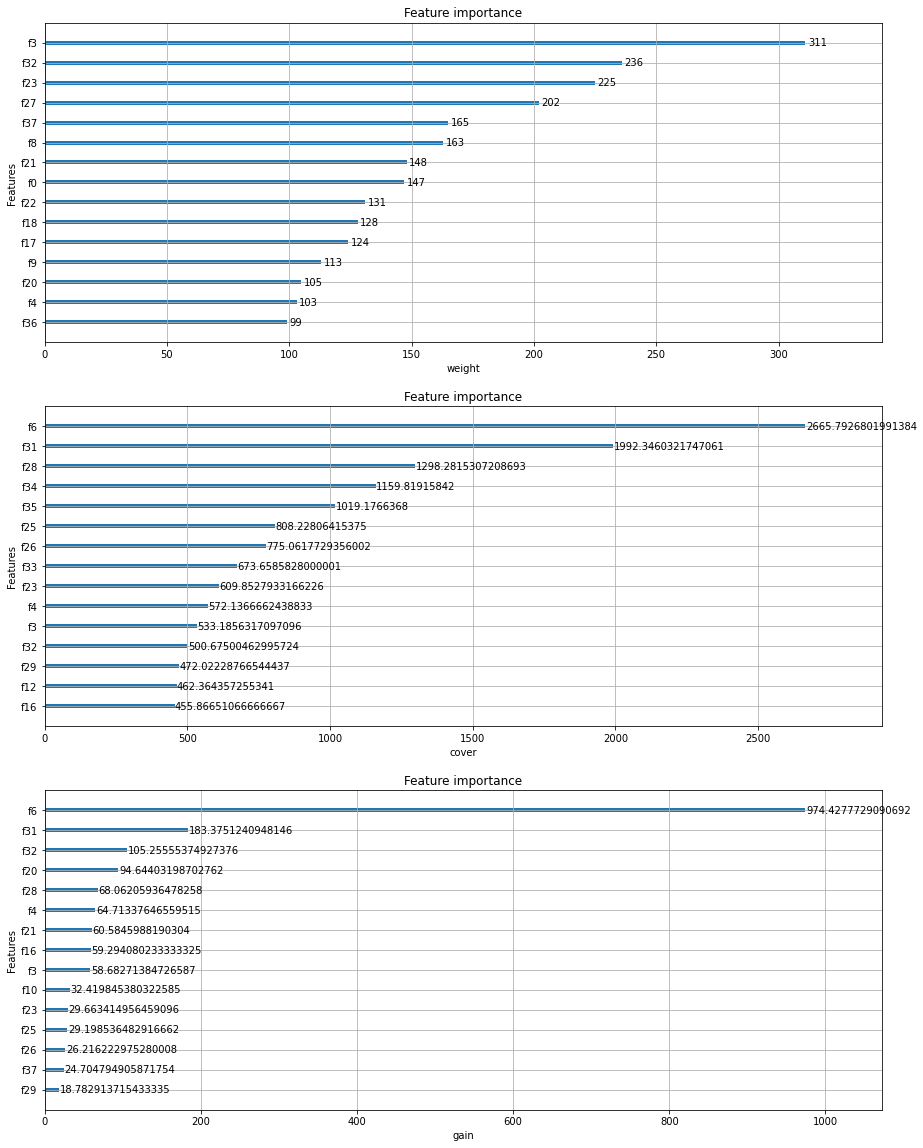

In [44]:
# visualize features importance

fig, ax = plt.subplots(3,1,figsize=(15,20))

importance_types = ['weight','cover','gain']

for i, imp_t in enumerate(importance_types):
    plot_importance(model, ax=ax[i], max_num_features=15, importance_type=imp_t,xlabel=imp_t)

fig.subplots_adjust(hspace=0.2)
plt.show()

Gain: il implique la contribution relative de l\attribut correspondant dans le modèle. Une forte valeur signifie que l'attribut est plus important

Cover: le nombre d observations relatif à un attribut ou le nombre de fois que l'attribut a ete utilisé pour creer un une feuille.

Les varibales les plus importantes :
sttl: Source to destination time to live value 
ct_dist_sport_ltm: 

In [186]:
features_desc = pd.read_csv('archive/NUSW-NB15_features.csv',encoding= 'unicode_escape')


# Statistics Analysis

In [20]:
columns_pca = numerical_columns[1:-2]
X = StandardScaler().fit_transform(df[columns_pca]) 
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state=0)

In [21]:
# on conserve toutes les composantes
pca = PCA()

In [22]:
pca.fit(X_train)

PCA()

In [23]:
X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)

In [24]:
# regression lineaire
reg = LinearRegression().fit(X_train_pca, y_train)

In [25]:
# coefficient de correlation R^2
reg.score(X_test_pca,y_test)

0.513992142299784

In [26]:
#https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
# get coeffcient of the model
coefficients = pd.concat([pd.DataFrame(categories_columns) ,pd.DataFrame(np.transpose(reg.coef_))], axis = 1)
coefficients.columns = ['Features','Coefficients']

In [27]:
coefs = pd.DataFrame({'Coefficients' : reg.coef_}, index=columns_pca)
coefs.sort_values(by='Coefficients',ascending=False)

Coefficients
ct_srv_dst         3.461037e+11
is_ftp_login       6.064081e-01
smean              1.363506e-01
dtcpb              1.231298e-01
stcpb              1.138344e-01
sloss              8.766556e-02
ct_dst_sport_ltm   8.601421e-02
dbytes             5.925143e-02
dttl               4.689983e-02
sbytes             3.002167e-02
djit               2.970028e-02
sjit               2.528811e-02
tcprtt             2.419949e-02
sttl               2.165747e-02
dpkts              1.078796e-02
sinpkt             2.424002e-03
spkts             -4.646301e-03
dloss             -4.945278e-03
rate              -1.202774e-02
swin              -1.479721e-02
dinpkt            -1.660728e-02
ct_ftp_cmd        -2.667069e-02
ct_srv_src        -2.805260e-02
sload             -2.921867e-02
dur               -6.760019e-02
dmean             -7.217383e-02
dload             -7.696080e-02
synack            -8.141518e-02
ackdat            -1.168194e-01
dwin              -1.297197e-01
response_body_len -1.675491e-01
trans_depth       -1.731911e-01
ct_src_dport_ltm  -1.981034e-01
ct_dst_ltm        -2.361927e-01
ct_flw_http_mthd  -3.268204e-01
ct_state_ttl      -3.295794e-01
ct_dst_src_ltm    -7.266731e-01
ct_src_ltm        -1.202579e+00

we cannot compare the magnitude of different coefficients since the features have different natural scales, and hence value ranges, because of their different unit of measure.

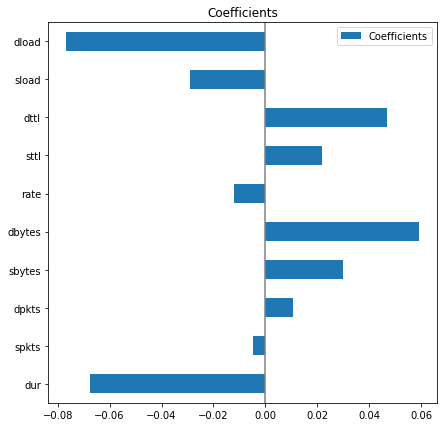

In [28]:
coefs[:10].plot(kind='barh', figsize=(9, 7))
plt.title('Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [29]:
df[columns_pca].std(axis=0).plot(kind='barh', figsize=(9, 15))
plt.title('Features std. dev.')
plt.subplots_adjust(left=.3)


# Evaluation and reporting

# XgClassififer

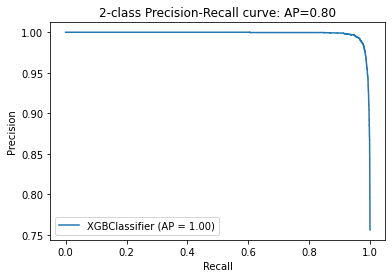

In [49]:
# Precision-Recall Curve

disp = plot_precision_recall_curve(model_xg, X_test_xg, y_test_xg)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(0.8))
plt.show()

In [55]:
# ROC curve

plot_roc_curve(model_xg, X_test_xg, y_test_xg) 
plt.show()

In [57]:
# learning curve 
N, train_score, val_score = learning_curve(model_xg,X_train_xg,y_train_xg,train_sizes=np.linspace(0.1,0.8,10), cv=5, scoring='recall')
    
plt.figure(figsize=(10,8))
plt.plot(N, train_score.mean(axis=1),label='train score')
plt.plot(N, val_score.mean(axis=1), label='val score')
plt.legend()
plt.show()

## Linear Regression